## 패키지 가져오기

In [1]:
from pykrx import stock
from pykrx import bond
import pandas_datareader.data as web
import FinanceDataReader as fdr

from talib import RSI, BBANDS, MACD

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from datetime import datetime
import time
from tqdm import tqdm

import multiprocessing as mp
from multiprocessing import Pool, Manager

import warnings
warnings.filterwarnings('ignore')

In [2]:
num_cores = mp.cpu_count()
print(f"사용가능한 코어 수: {num_cores}")

사용가능한 코어 수: 8


In [3]:
# 2023년 3월 1일 기준 KOSPI와 KOSDAQ의 종목 수를 파악
start_date, end_date = "2015-02-11", "2023-03-01"
kospi_tickers = stock.get_market_ticker_list(end_date, market='KOSPI')
kosdaq_tickers = stock.get_market_ticker_list(end_date, market='KOSDAQ')
all_tickers = kospi_tickers + kosdaq_tickers

print("KOSPI 종목 수: ", len(kospi_tickers))
print("KOSDAQ 종목 수: ", len(kosdaq_tickers))
print("전체 종목 수: ", len(all_tickers))

KOSPI 종목 수:  943
KOSDAQ 종목 수:  1615
전체 종목 수:  2558


## 전략 수립 및 구현

14일을 기준으로 RSI를 계산하고, RSI가 50을 상향돌파하면 매수, 50을 하향돌파하면 매도.  
자산은 리밸런싱 시점에 KOSPI의 거래대금 기준 50위안에 드는 주식만을 대상으로 함.  
이 때, 각 자산의 매수 및 매도 비중은 모두 동일 가중 방식을 사용하여 결정. 리밸런싱 주기는 5영업일로 설정.  
2015년 3월~2023년 2월을 기준으로 전략을 실행하여 백테스트 진행.  
백테스트한 결과, 연간 약 2% 정도의 수익률을 기록  

최근에 나쁜 수익률을 보이고 있고, 변동성이 상당히 크다는 점은 우려점

In [4]:
# 1주(5 영업일)을 기준으로 rebalancing을 실시
rebalance_period = 5
rebalance_date = stock.get_market_ohlcv(start_date, end_date, "005930").index[::rebalance_period]

In [5]:
# 각 시점에서 거래대금 상위 50위인 주식들의 정보를 가져옴
# 각 시점에서 거래대금 상위 50위인 주식들의 정보는 rebalance_dict에
# 한번이라도 top50였던 종목들의 정보를 all_tickers에 담음
all_tickers = []
rebalance_dict = {}
rebalance_date = rebalance_date.strftime("%Y-%m-%d")
for date in tqdm(rebalance_date):
    marketcap = stock.get_market_cap(date,market='KOSPI')['거래대금']
    top50 = list(marketcap.sort_values(ascending=False).head(50).index)
    rebalance_dict[date] = top50
    all_tickers += top50
rebalance_df = pd.DataFrame(rebalance_dict)
all_tickers = list(set(all_tickers))

100%|██████████| 397/397 [03:38<00:00,  1.82it/s]


In [6]:
def return_price_df(tickers, start_date, end_date):
    df = pd.DataFrame()
    for ticker in tqdm(tickers):
        price_df = stock.get_market_ohlcv(start_date, end_date, ticker)['종가'].to_frame(ticker)
        df = pd.concat([df, price_df], axis=1)
    return df

price_df = return_price_df(all_tickers, start_date, end_date)
price_df.to_csv('RSI_price_df.csv')

price_df = pd.read_csv('RSI_price_df.csv', index_col=0)
price_df = price_df.fillna(0)
price_df.head()

100%|██████████| 690/690 [00:55<00:00, 12.48it/s]


,024110,024900,003535,001060,003300,014820,007460,032640,300720,051905,...,117580,088350,071970,002320,004310,005490,010950,000720,161390,100250
날짜,,,,,,,,,,,,,,,,,,,,,
2015-02-11,13650,2975,1945,12194,19760,24500,8420,11600,0.0,328500,...,5760,7760,638912,57137,2656,263500,62000,42714,49800,4100
2015-02-12,13500,3115,1966,12194,19995,23950,8465,11850,0.0,331500,...,5800,7710,638912,59613,2626,261500,59900,41157,48950,4125
2015-02-13,13600,3100,1991,12359,19642,23500,8374,11950,0.0,335000,...,5790,7700,638912,59041,2568,264500,62800,41546,48800,4085
2015-02-16,13350,3085,1937,12815,19936,22950,8420,11650,0.0,334000,...,5700,7780,638912,57899,2724,267500,61900,42908,48200,4000
2015-02-17,13500,3225,1970,12524,19936,23150,8374,11650,0.0,330000,...,5680,7780,638912,56185,2724,268000,62800,44076,48000,4105


In [7]:
# RSI 계산
# timeperiod=14를 사용
rsi = price_df.copy()
for col in price_df.columns:
    rsi[col] = RSI(price_df[col], timeperiod=14)
rsi = rsi.fillna(0)

In [8]:
def calculate_weights(rsi, long=50, short=50):
    signal = rsi.copy()
    for i in tqdm(range(len(rebalance_date)-1)):
        day1, day2 = rebalance_date[i], rebalance_date[i+1]
        temp = rsi.loc[[rebalance_date[i], rebalance_date[i+1]], 
                   list(set(rebalance_df[rebalance_date[i]]) & set(rebalance_df[rebalance_date[i+1]]))]
        for j in range(len(temp.columns)):
            if (temp.iloc[0, j] < long) & (temp.iloc[1, j] >= long):
                signal.loc[temp.index[1], temp.columns[j]] = 1
            elif (temp.iloc[0, j]  > short) & (temp.iloc[1, j] <= short):
                signal.loc[temp.index[1],temp.columns[j]] = -1
    def calculate_weights_from_signal(arr):
        long_signal = (arr == 1).astype(int)
        short_signal = (arr == -1).astype(int)
        long_cnt = np.sum(long_signal)
        short_cnt = np.sum(short_signal)
        if long_cnt > 0:
            long_signal = long_signal / long_cnt
        if short_cnt > 0:
            short_signal = -1 * short_signal / short_cnt
        return long_signal + short_signal
    signal = signal.apply(calculate_weights_from_signal, axis=1)
    return signal
weights = calculate_weights(rsi)

100%|██████████| 396/396 [00:02<00:00, 185.77it/s]


In [9]:
# rebalance를 반영해서 weight를 수정
for date in weights.index:
    if date not in rebalance_date:
        weights.loc[date, :] = np.nan
weights = weights.fillna(method='ffill')
weights.index = pd.to_datetime(weights.index, format='%Y-%m-%d')

In [10]:
# 수익률 계산
# NaN 값은 일단 0으로 처리
fwd_return = price_df.pct_change().shift(-1)
fwd_return = fwd_return.fillna(0)
fwd_return.index = pd.to_datetime(fwd_return.index, format='%Y-%m-%d')
fwd_return.tail()

,024110,024900,003535,001060,003300,014820,007460,032640,300720,051905,...,117580,088350,071970,002320,004310,005490,010950,000720,161390,100250
날짜,,,,,,,,,,,,,,,,,,,,,
2023-02-22,0.010934,0.005693,-0.004762,-0.009368,-0.011754,0.003778,-0.005900,-0.010036,-0.011438,0.000000,...,-0.013793,0.137652,0.035144,-0.004619,-0.003976,-0.001506,-0.009732,0.014304,0.006553,0.014400
2023-02-23,0.002950,-0.009434,-0.011164,-0.021277,-0.000915,-0.032622,-0.026706,0.005530,-0.002479,-0.010256,...,-0.010989,0.008897,-0.003086,0.002320,-0.019960,-0.028658,0.008600,-0.025641,-0.016927,0.001577
2023-02-24,0.001961,-0.009524,-0.006452,0.009662,0.005495,0.029831,0.019512,-0.010999,-0.021541,-0.013817,...,0.000000,0.045855,0.029412,-0.023148,-0.020367,-0.009317,-0.009744,-0.017105,-0.007947,0.006299
2023-02-27,0.015656,0.019231,0.000000,-0.004785,0.004554,-0.002519,0.027512,0.025950,0.010161,0.001751,...,-0.017172,0.003373,0.004511,-0.002370,0.004158,-0.003135,-0.007380,-0.025435,-0.006676,0.014085
2023-02-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
# 일별 수익률 계산
daily_return = weights.mul(fwd_return).sum(axis=1)
daily_return = daily_return[(daily_return.index >="2015-03-01") & (daily_return.index < "2023-02-28")]
daily_return = daily_return.to_frame("daily_return")
daily_return

,daily_return
날짜,
2015-03-02,0.000000
2015-03-03,0.000000
2015-03-04,0.000000
2015-03-05,0.000000
2015-03-06,0.000000
...,...
2023-02-21,0.004870
2023-02-22,0.020937
2023-02-23,-0.013110


In [12]:
# 누적수익률 계산
cumulative_return = np.exp(np.log(daily_return['daily_return'] + 1).cumsum())-1
cumulative_return = cumulative_return.to_frame("cumulative_return")
cumulative_return

,cumulative_return
날짜,
2015-03-02,0.000000
2015-03-03,0.000000
2015-03-04,0.000000
2015-03-05,0.000000
2015-03-06,0.000000
...,...
2023-02-21,0.151259
2023-02-22,0.175363
2023-02-23,0.159955


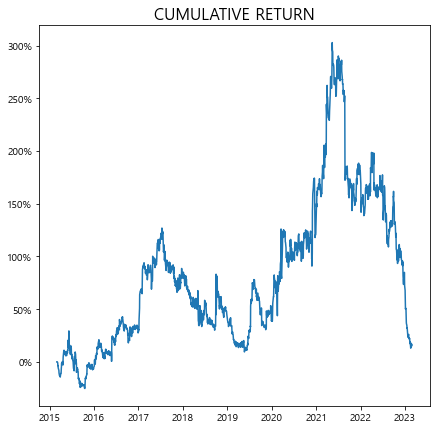

In [13]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.plot(cumulative_return)
ax.set_title("CUMULATIVE RETURN", fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

## 자세한 결과 분석

In [14]:
import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

Text(0.5, 1.0, 'Rolling Sharpe Ratio (3 Months)')

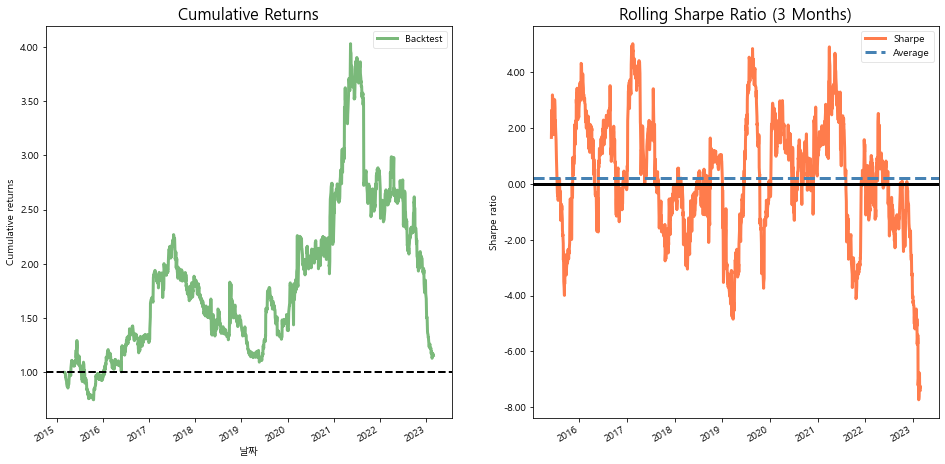

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

plot_rolling_returns(daily_return['daily_return'],
                     logy=False,
                     legend_loc='best',
                     volatility_match=False,
                    ax=axes[0])
plot_rolling_sharpe(daily_return['daily_return'], ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns', fontsize=16)
axes[1].set_title('Rolling Sharpe Ratio (3 Months)', fontsize=16)

Start date,2015-03-02
End date,2023-02-27
Total months,93
,Backtest
Annual return,1.852%
Cumulative returns,15.421%
Annual volatility,40.368%
Sharpe ratio,0.25
Calmar ratio,0.03
Stability,0.56
Max drawdown,-71.958%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,71.96,2021-05-13,2023-02-17,NaT,NaN
1,51.78,2017-07-13,2019-05-22,2020-12-01,884
2,42.23,2015-06-09,2015-10-19,2016-07-05,281
3,20.56,2020-12-17,2020-12-23,2021-02-19,47
4,17.37,2016-08-23,2016-10-10,2017-01-09,100


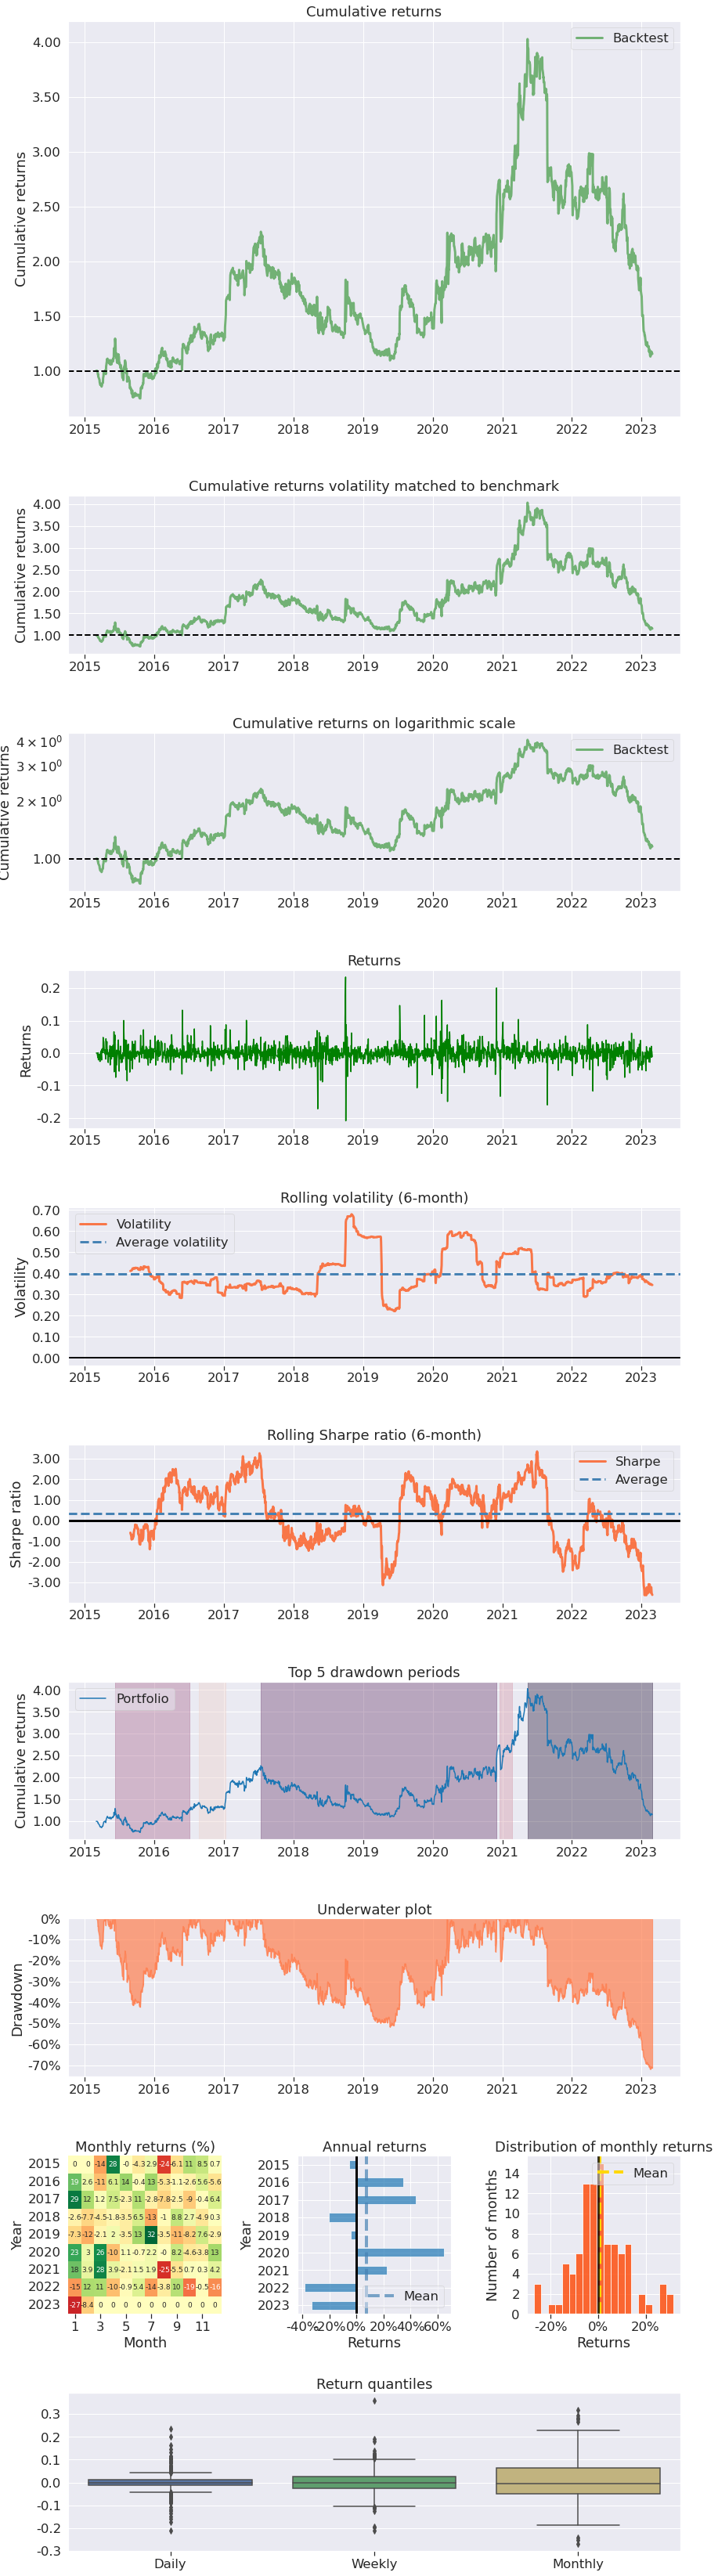

In [16]:
pf.create_returns_tear_sheet(daily_return['daily_return'])

## 전략수정(매일 리밸런싱 실시)

위의 RSI 기반 전략의 성과가 저조하여 리밸런싱 주기를 daily로 변경

성과가 훨씬 악화되고 있음을 확인

In [17]:
rebalance_date = stock.get_market_ohlcv(start_date, end_date, "005930").index

In [18]:
# 각 시점에서 marketcap 상위 50위인 주식들의 정보를 가져옴
# 각 시점에서 marketcap 상위 50위인 주식들의 정보는 rebalance_dict에
# 한번이라도 top50였던 종목들의 정보를 all_tickers에 담음
all_tickers = []
rebalance_dict = {}
rebalance_date = rebalance_date.strftime("%Y-%m-%d")
for date in tqdm(rebalance_date):
    marketcap = stock.get_market_cap(date,market='KOSPI')['거래대금']
    top50 = list(marketcap.sort_values(ascending=False).head(50).index)
    rebalance_dict[date] = top50
    all_tickers += top50
rebalance_df = pd.DataFrame(rebalance_dict)
all_tickers = list(set(all_tickers))

def return_price_df(tickers, start_date, end_date):
    df = pd.DataFrame()
    for ticker in tqdm(tickers):
        price_df = stock.get_market_ohlcv(start_date, end_date, ticker)['종가'].to_frame(ticker)
        df = pd.concat([df, price_df], axis=1)
    return df

price_df = return_price_df(all_tickers, start_date, end_date)
price_df.to_csv('RSI_price_df.csv')

price_df = pd.read_csv('RSI_price_df.csv', index_col=0)
price_df = price_df.fillna(0)

rsi = price_df.copy()
for col in price_df.columns:
    rsi[col] = RSI(price_df[col], timeperiod=14)
rsi = rsi.fillna(0)

def calculate_weights(rsi, long=50, short=50):
    signal = rsi.copy()
    for i in tqdm(range(len(rebalance_date)-1)):
        day1, day2 = rebalance_date[i], rebalance_date[i+1]
        temp = rsi.loc[[rebalance_date[i], rebalance_date[i+1]], 
                   list(set(rebalance_df[rebalance_date[i]]) & set(rebalance_df[rebalance_date[i+1]]))]
        for j in range(len(temp.columns)):
            if (temp.iloc[0, j] < long) & (temp.iloc[1, j] >= long):
                signal.loc[temp.index[1], temp.columns[j]] = 1
            elif (temp.iloc[0, j]  > short) & (temp.iloc[1, j] <= short):
                signal.loc[temp.index[1],temp.columns[j]] = -1
    def calculate_weights_from_signal(arr):
        long_signal = (arr == 1).astype(int)
        short_signal = (arr == -1).astype(int)
        long_cnt = np.sum(long_signal)
        short_cnt = np.sum(short_signal)
        if long_cnt > 0:
            long_signal = long_signal / long_cnt
        if short_cnt > 0:
            short_signal = -1 * short_signal / short_cnt
        return long_signal + short_signal
    signal = signal.apply(calculate_weights_from_signal, axis=1)
    return signal
weights = calculate_weights(rsi)
weights.index = pd.to_datetime(weights.index, format='%Y-%m-%d')

100%|██████████| 1980/1980 [00:11<00:00, 170.19it/s]


In [19]:
# 일별 수익률 계산
daily_return = weights.mul(fwd_return).sum(axis=1)
daily_return = daily_return[(daily_return.index >="2015-03-01") & (daily_return.index < "2023-02-28")]
daily_return = daily_return.to_frame("daily_return")
daily_return

,daily_return
날짜,
2015-03-02,0.000000
2015-03-03,0.000000
2015-03-04,0.000000
2015-03-05,0.000000
2015-03-06,-0.009490
...,...
2023-02-21,0.003443
2023-02-22,-0.013483
2023-02-23,-0.023276


In [20]:
# 누적수익률 계산
cumulative_return = np.exp(np.log(daily_return['daily_return'] + 1).cumsum())-1
cumulative_return = cumulative_return.to_frame("cumulative_return")
cumulative_return

,cumulative_return
날짜,
2015-03-02,0.000000
2015-03-03,0.000000
2015-03-04,0.000000
2015-03-05,0.000000
2015-03-06,-0.009490
...,...
2023-02-21,-0.938332
2023-02-22,-0.939163
2023-02-23,-0.940579


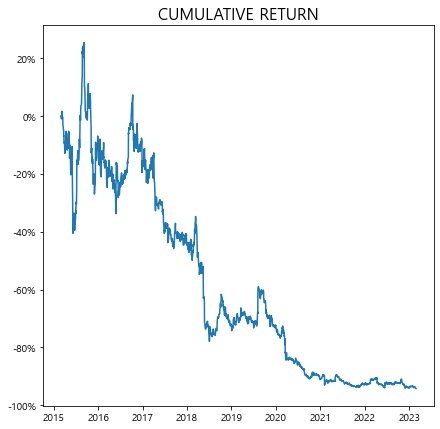

In [21]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.plot(cumulative_return)
ax.set_title("CUMULATIVE RETURN", fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

Text(0.5, 1.0, 'Rolling Sharpe Ratio (3 Months)')

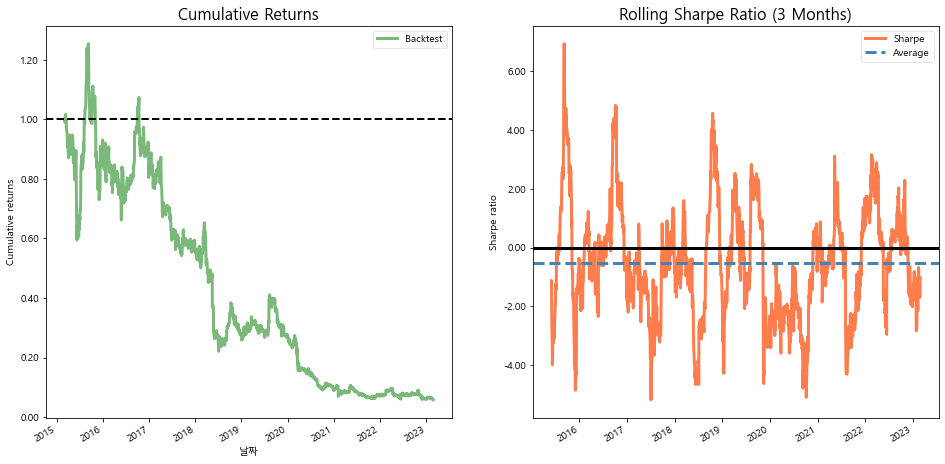

In [22]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

plot_rolling_returns(daily_return['daily_return'],
                     logy=False,
                     legend_loc='best',
                     volatility_match=False,
                    ax=axes[0])
plot_rolling_sharpe(daily_return['daily_return'], ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns', fontsize=16)
axes[1].set_title('Rolling Sharpe Ratio (3 Months)', fontsize=16)

Start date,2015-03-02
End date,2023-02-27
Total months,93
,Backtest
Annual return,-30.501%
Cumulative returns,-94.184%
Annual volatility,47.004%
Sharpe ratio,-0.54
Calmar ratio,-0.32
Stability,0.93
Max drawdown,-95.363%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,95.36,2015-09-08,2023-02-27,NaT,NaN
1,41.49,2015-03-11,2015-06-09,2015-08-11,110
2,2.07,2015-08-31,2015-09-02,2015-09-08,7
3,1.85,2015-08-27,2015-08-28,2015-08-31,3
4,0.95,2015-03-05,2015-03-06,2015-03-09,3


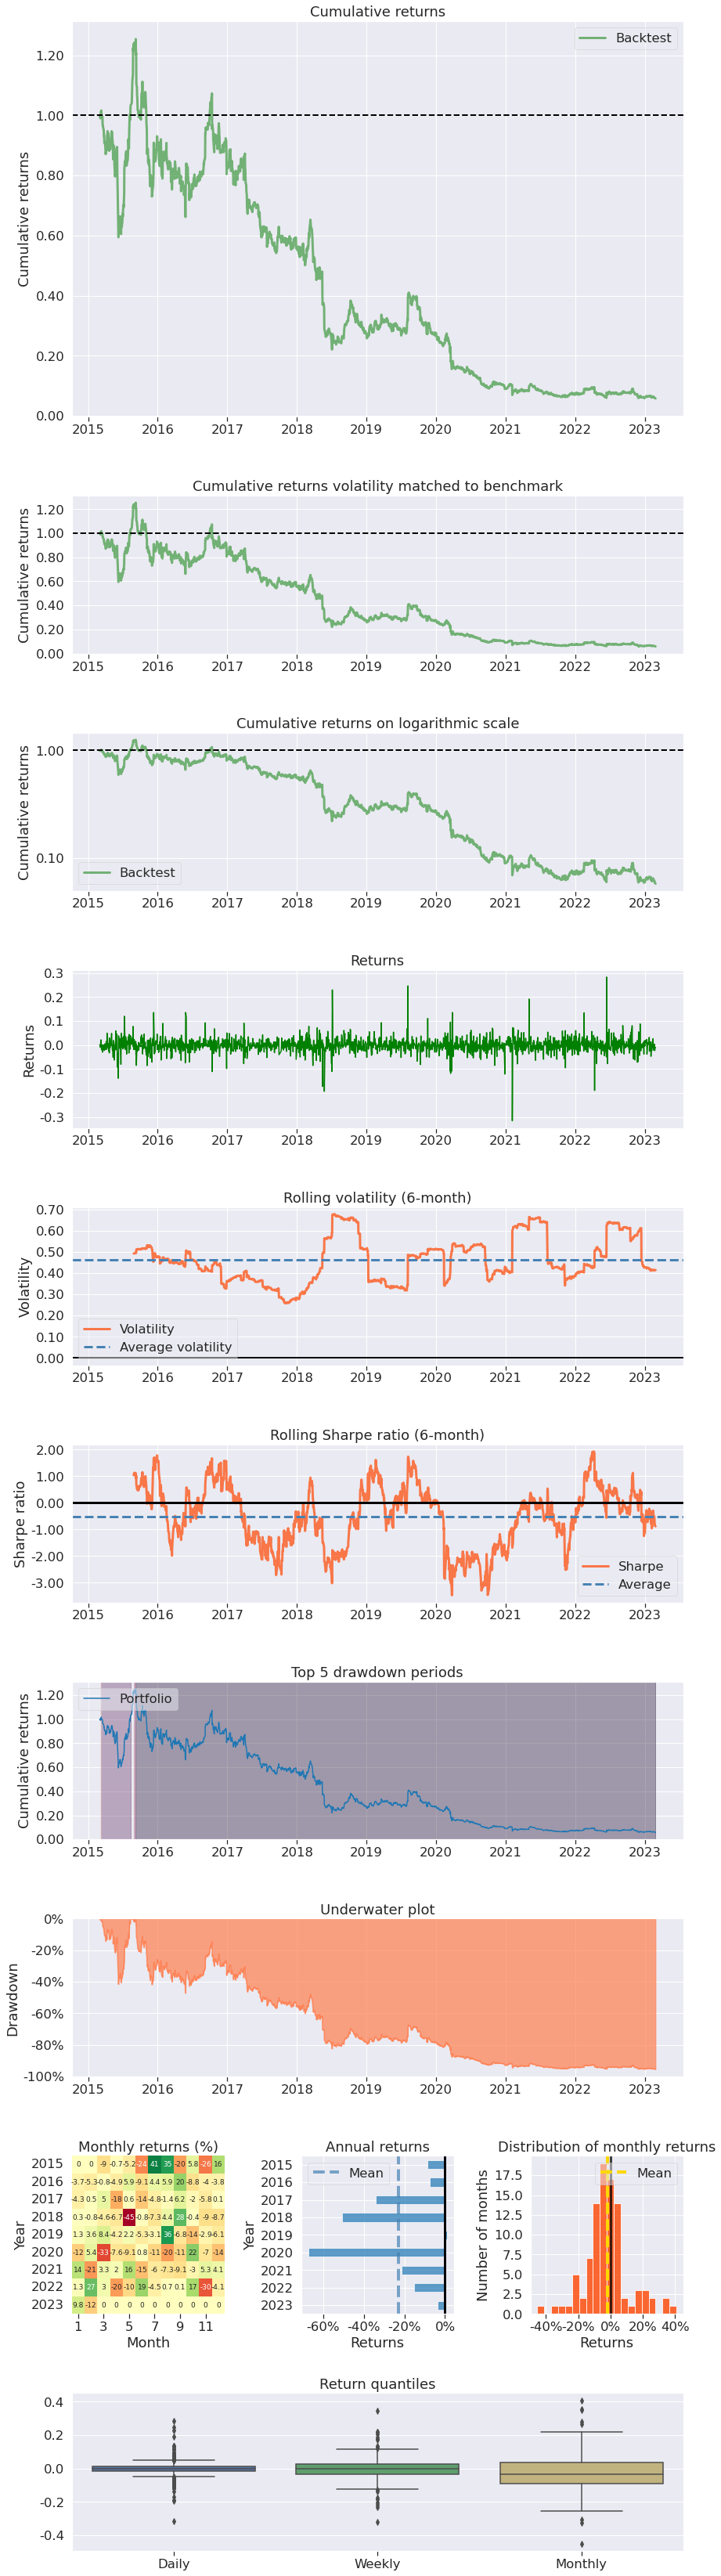

In [23]:
pf.create_returns_tear_sheet(daily_return['daily_return'])